# BRDF Correction Test

In [43]:
import numpy as np
import rasterio
from rasterio.plot import show

from matplotlib import pyplot

from s2brdf import kernels, brdf


### Input data
There are two multi-band rasters that cover an area in the overlap zone between relative orbits 83 and 40. 

The reflectance values are leaf-on cloud-free mosaicked images obtained using the Sentinel Hub batch processing API. The mosaic images represent the median value of summertime (June/July/August) non-cloud/shadow pixels in Sentinel 2 L2A collection during 2019, 2020, and 2021. The images have been resampled to 30 meter resolution and reprojected to US National Atlas Equal Area (EPSG:2163).

The view/solar zenith and azimuth angle rasters correspond to a collection date in July 2021 obtained using the Sentinel Hub request API. The units are degrees and the original 5000m resolution rasters were resampled and reprojected to match the spectral data.

In [44]:
band_key = {
    'B02': 0,
    'B03': 1,
    'B04': 2,
    'B08': 3,
    'B11': 4,
    'B12': 5,
    'vza': 6,
    'vaa': 7,
    'sza': 8,
    'saa': 0,
}

Read the rasters, replace -9999.0 with NA

In [45]:
orbit40_tif = "../data/orbit40.tif"
orbit83_tif = "../data/orbit83.tif"

with rasterio.open(orbit40_tif) as src:
    orbit40 = src.read()
    orbit40[orbit40 == -9999.0] = np.nan

with rasterio.open(orbit83_tif) as src:
    orbit83 = src.read()
    orbit83[orbit83 == -9999.0] = np.nan


For plotting the rasters, identify the 0.02 and 0.98 quantiles for each band for the min/max on RGB scale.

In [46]:
band_max = {
    band: np.nanquantile([orbit40[band], orbit83[band]], 0.98) for band in range(0, len(orbit40))
}
band_min = {
    band: np.nanquantile([orbit40[band], orbit83[band]], 0.02) for band in range(0, len(orbit40))
}

In [47]:
orbit40_scaled = orbit40.copy()
orbit83_scaled = orbit83.copy()
for band in [0, 1, 2, 3]:
    orbit40_scaled[band] = (orbit40_scaled[band] - band_min[band]) / (band_max[band] - band_min[band])
    orbit83_scaled[band] = (orbit83_scaled[band] - band_min[band]) / (band_max[band] - band_min[band])


2021-09-11 07:44:07,325 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-09-11 07:44:07,344 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'Orbit 83: no correction'}>

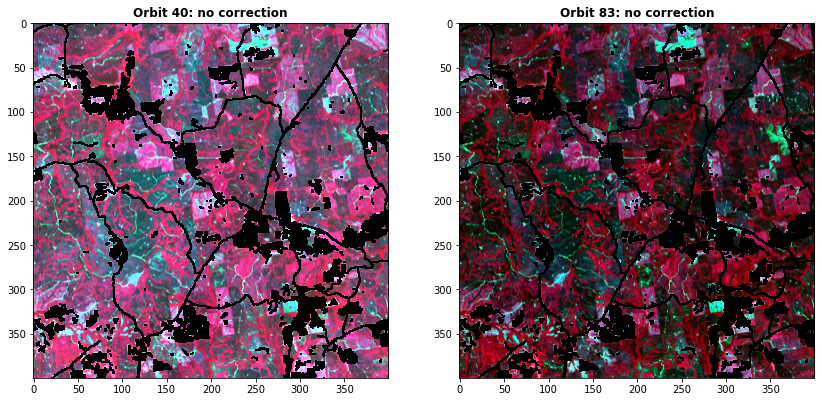

In [48]:
fig, (ax40, ax83) = pyplot.subplots(1, 2, figsize=(14, 7))
show(orbit40_scaled[[3, 2, 1]], adjust=None, ax=ax40, title='Orbit 40: no correction')
show(orbit83_scaled[[3, 2, 1]], adjust=None, ax=ax83, title='Orbit 83: no correction')


Notice the difference in brightness between the two images. This is what I am trying to correct.

## BRDF correction
Calculate the BRDF-adjusted reflectance using `brdf.calc_nbar`.

In [49]:
orbit40_nbar = orbit40.copy()
orbit83_nbar = orbit83.copy()
for band in ["B02", "B03", "B04", "B08", "B11", "B12"]:
    orbit40_nbar[band_key[band]] = brdf.calc_nbar(
        r_s2=orbit40_nbar[band_key[band]],
        band=band,
        sza=kernels.deg2rad(orbit40_nbar[band_key['sza']]),
        vza=kernels.deg2rad(orbit40_nbar[band_key['vza']]),
        saa=kernels.deg2rad(orbit40_nbar[band_key['saa']]),
        vaa=kernels.deg2rad(orbit40_nbar[band_key['vaa']])
    )
    orbit83_nbar[band_key[band]] = brdf.calc_nbar(
        r_s2=orbit83_nbar[band_key[band]],
        band=band,
        sza=kernels.deg2rad(orbit83_nbar[band_key['sza']]),
        vza=kernels.deg2rad(orbit83_nbar[band_key['vza']]),
        saa=kernels.deg2rad(orbit83_nbar[band_key['saa']]),
        vaa=kernels.deg2rad(orbit83_nbar[band_key['vaa']])
    )



Apply same scale to the resulting images for plotting alongside originals.

In [50]:
orbit40_nbar_scaled = orbit40_nbar.copy()
orbit83_nbar_scaled = orbit83_nbar.copy()
for band in [0, 1, 2, 3]:
    orbit40_nbar_scaled[band] = (orbit40_nbar_scaled[band] - band_min[band]) / (band_max[band] - band_min[band])
    orbit83_nbar_scaled[band] = (orbit83_nbar_scaled[band] - band_min[band]) / (band_max[band] - band_min[band])


2021-09-11 07:44:09,012 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-09-11 07:44:09,028 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'Orbit 83: BRDF correction'}>

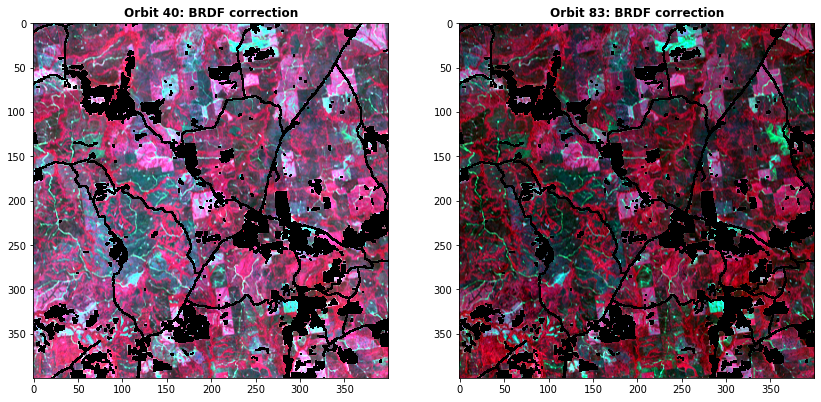

In [51]:
fig, (ax40, ax83) = pyplot.subplots(1, 2, figsize=(14, 7))
show(orbit40_nbar_scaled[[3, 2, 1]], adjust=None, ax=ax40, title='Orbit 40: BRDF correction')
show(orbit83_nbar_scaled[[3, 2, 1]], adjust=None, ax=ax83, title='Orbit 83: BRDF correction')


The corrections do not seem to have made much of a difference at this scale.

2021-09-11 07:44:09,874 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-09-11 07:44:09,890 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'Orbit 40: BRDF correction'}>

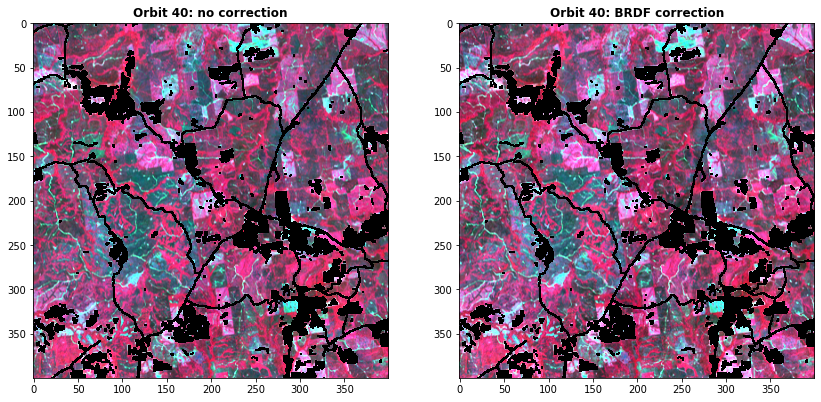

In [52]:
fig, (ax40, ax83) = pyplot.subplots(1, 2, figsize=(14, 7))
show(orbit40_scaled[[3, 2, 1]], adjust=None, ax=ax40, title='Orbit 40: no correction')
show(orbit40_nbar_scaled[[3, 2, 1]], adjust=None, ax=ax83, title='Orbit 40: BRDF correction')


2021-09-11 07:44:10,837 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-09-11 07:44:10,855 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'Orbit 83: BRDF correction'}>

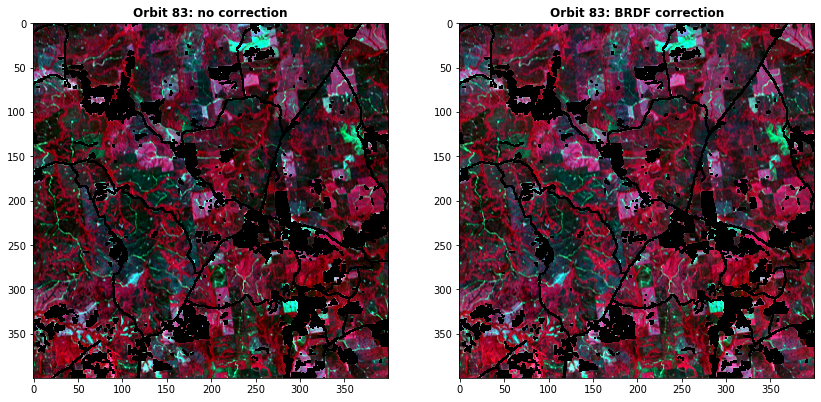

In [53]:
fig, (ax40, ax83) = pyplot.subplots(1, 2, figsize=(14, 7))
show(orbit83_scaled[[3, 2, 1]], adjust=None, ax=ax40, title='Orbit 83: no correction')
show(orbit83_nbar_scaled[[3, 2, 1]], adjust=None, ax=ax83, title='Orbit 83: BRDF correction')


Maybe something will jump out in the C-factor values?

In [54]:
c_lambda40 = brdf.calc_c_lambda(
    band="B04",
    sza=kernels.deg2rad(orbit40[band_key['sza']]),
    vza=kernels.deg2rad(orbit40[band_key['vza']]),
    saa=kernels.deg2rad(orbit40[band_key['saa']]),
    vaa=kernels.deg2rad(orbit40[band_key['vaa']])
)
c_lambda83 = brdf.calc_c_lambda(
    band="B04",
    sza=kernels.deg2rad(orbit83[band_key['sza']]),
    vza=kernels.deg2rad(orbit83[band_key['vza']]),
    saa=kernels.deg2rad(orbit83[band_key['saa']]),
    vaa=kernels.deg2rad(orbit83[band_key['vaa']])
)


<AxesSubplot:title={'center':'Orbit 83: C-factor'}>

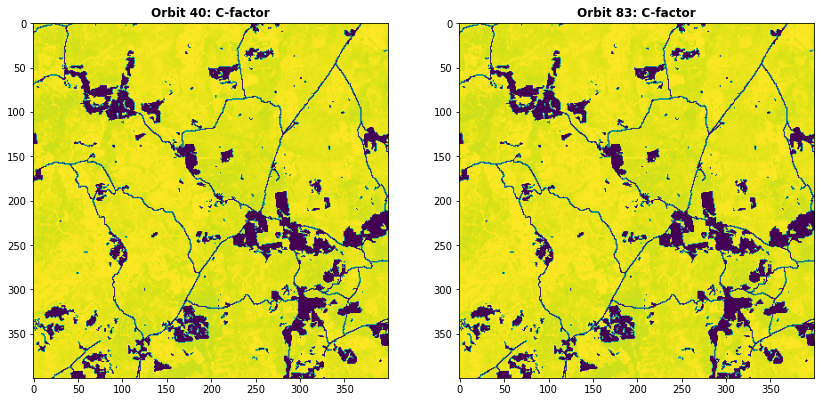

In [55]:
c_lambda40_scaled = np.int16(100 * c_lambda40)
c_lambda83_scaled = np.int16(100 * c_lambda40)

fig, (ax40, ax83) = pyplot.subplots(1, 2, figsize=(14, 7))
show(c_lambda40_scaled, adjust=None, ax=ax40, title='Orbit 40: C-factor')
show(c_lambda83_scaled, adjust=None, ax=ax83, title='Orbit 83: C-factor')
